# Etivity 2: Deep Convolutional Neural Network on CIFAR-10 Dataset

In this assignment, we will gain some practical experience of coding a deep convolutional neural network in Tensorflow. The simplest way to code a network is to use the High level Keras API within Tensorflow 2.5.  

## (a) Introduction

 In this assignment to reduce training time and computation, we will train our network using the simple [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset.
![link text](https://paperswithcode.com/media/datasets/CIFAR-10-0000000431-b71f61c0_U5n3Glr.jpg)

The goal of this Etivity is to build and train your own Deep Convolutional Neural Network. This notebook contains standard keras/Tensorflow code to perform data processing, training set up and testing metrics, as outlined in the steps below. This will allow you to focus on developing the architecture & code for your network. 

1. Load Dataset - We will import the CIFAR-10 Dataset using the Tensorflow Data Set API.
2. Prepare Data - We will slightly modify the dataset before it is sent to the model for training.
3. Model Coding - We will write code to build the model using the Tensorflow keras API.
  * **You will code your neural network model in this section**
4. Compile Model - We will complile the model and verify that it has been correctly constructed.
5. Train Model - We will train the model using the imported dataset.
6. Test Model - We test the model on the training data and obtain a classification report and confusion matrix.

The principal resource for understanding the basics of how to code & train Deep Convolutional Neural Network architectures in Tensorflow/keras are the Tensorflow tutorials. Tutorials on [image classification](https://www.tensorflow.org/tutorials/images/classification) and [data augmentation](https://www.tensorflow.org/tutorials/images/data_augmentation) are useful for this Etivity.  


## (b) Notes on Architecture selection & development

A key task in this Etivity is selecting an appropriate architecture. You can base your archicture on any of the types seen in the lecture notes or published literature. It is however recommended to ensure you can get a standard CNN type architecture to successfully train before attempting a more complex architecture or adding further enhancements to your network to improve performance.
   Many published networks are designed to work with larger sized input images (e.g. 224 x 224). Often large (e.g. 7 x 7) convolution kernels and pooling layers are first applied to the input image, which agressively reduce the spatial dimensions of the network. As the CIFAR-10 dataset only has 32 x 32 images, it is recommended that just an intial 3 x 3 convolution is applied to the input image (as shown in the figure below), which will preserve the spatial dimensions of the input, before any other layers are added. It is expected that as you add more layers to the network the spatial dimensions will reduce and there will also be a corresponding increase the number of channels of the output feature map. The architecture will end with a [global average pooling layer](https://arxiv.org/pdf/1312.4400.pdf) and a fully-connected layer (called a *dense* layer in Keras/Tensorflow) with softmax activation which gives us our 10 class predictions. A skeleton code has been provided for any general architure using this structure in section 3.
![link text](https://github.com/tonyscan6003/CE6003/blob/master/images/Architecture_outline.jpg?raw=true)


#House Keeping

In [1]:
from __future__ import print_function

%tensorflow_version 2.x
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Activation
from tensorflow.keras.layers import GlobalAveragePooling2D,AveragePooling2D, Input, Flatten, MaxPooling2D, add,Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10

import numpy as np

To ensure this assignment runs as fast as possible, from the menu above select **Edit > Notebook settings** or **Runtime > Change runtime type** and select GPU as the Hardware accelerator option.

Let's test that we are running using the GPU. 

In [2]:
tf.test.gpu_device_name()

'/device:GPU:0'

#1. Load Dataset

In this assignment, we will be using the [CIFAR-10 dataset](http://www.cs.toronto.edu/~kriz/cifar.htmlhttps://). CIFAR-10 is often used as a "Hello World" dataset that is often used to ensure a network architecture is working before moving on to training with more complex datasets.

The CIFAR-10 dataset consists of 60,000 32x32 color images in 10 classes (airplane, automobile, **bird**, cat, deer, dog, frog, horse, ship, truck), with 6,000 images per class. There are 50,000 training images and 10,000 test images. 

We will use the [Tensorflow dataset](https://www.tensorflow.org/datasets/catalog/cifar10) API to download the CIFAR10 dataset.

In [3]:
batch_size = 32 # Default Batch size (can be adjusted)
H_trg =32       # Image Height (fixed)
W_trg =32       # image Width (fixed)

# Labels corresponding to categories
label_str = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [4]:
# We initally load the raw training/validation/test dataset
import tensorflow_datasets as tfds
ds,info= tfds.load("cifar10",with_info=True)

raw_train = tfds.load('cifar10', split='train[0%:90%]')
raw_val = tfds.load('cifar10', split='train[91%:100%]')
raw_test = tfds.load('cifar10', split='test')

# 2. Prepare Data

After importing raw datasets using tfds load, we create an input pipeline that processes & batches this data before it is supplied to the model for training using the virtual machine GPU.

In [5]:
def data_pipe(image,label):
  image = tf.image.convert_image_dtype(image, tf.float32) # Cast and normalize the image to [0,1]
  image = image-0.5 
  label = tf.cast(label, tf.float32)
  return image,label


In [6]:
def gen_tr_datasets(src_dataset):    
    # Define Datasets 
    #src_dataset = src_dataset.shuffle(num_train_examples) 
    tr_dataset = src_dataset.map(lambda x: (x['image'],x['label']))  
    tr_dataset = tr_dataset.map(data_pipe)
    tr_dataset = tr_dataset.batch(batch_size) 
    return tr_dataset

def gen_val_datasets(src_dataset): 
    # Define Datasets 
    test_dataset = src_dataset.map(lambda x: (x['image'],x['label']))  
    test_dataset = test_dataset.map(data_pipe)
    test_dataset = test_dataset.batch(batch_size) 
    return test_dataset
# Generate the datasets
train_dataset = gen_tr_datasets(raw_train)
val_dataset = gen_val_datasets(raw_val)
test_dataset = gen_val_datasets(raw_test)

Plot some examples of the training dataset.

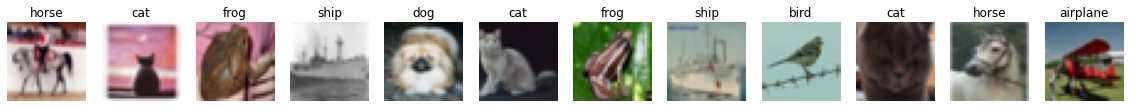

In [8]:
i=0
n_plots = 12 # number of plots
f, axarr = plt.subplots(1,n_plots,figsize=(20,10))

for image, label in train_dataset.take(n_plots):  # Only take a single example
  axarr[i].imshow(image[0,:,:,:]+0.5)  #*255)   #+128   
  axarr[i].axis('off')
  axarr[i].title.set_text(label_str[int(label[0])])
  i = i+1



In [7]:
#image[0,:,:,:]
type(train_dataset)

tensorflow.python.data.ops.dataset_ops.BatchDataset

# 3. Model Coding

In this section You may develop your own model architecture to perform image recognition with the CIFAR-10 Dataset.

There are some recommendations and helper code in this section that you may choose use, or you can also use your own approach to creating your architecture. 

Please Leave a note at the end of the notebook explaining your approach/results for the e-moderator.





 
## Note 1: Keras Function/Sequential API

Within Keras there are two API's for coding network models: Sequential and functional. You may have already used the [seqential model](https://https://www.tensorflow.org/guide/keras/sequential_model) to code basic artifical neural networks. The [functional model](https://www.tensorflow.org/guide/keras/functional) is more general and enables us to include feedforward paths which are required to code more advanced networks such as ResNet or DenseNet. The functional API has been used to code the helper functions repeating unit/top level skeleton detailed below.

## Note 2: Repeating Unit

In many Deep architectures there will often be a repeating unit(s) that is composed of a sequence of layers, for example Conv,ReLU & Batch Normalisation. Specific layers can be turned on or off as required. This also allows experimentation of the entire architecture with/without specific layers (e.g. Batch Normalisation)  You may wish to create other combinations of layers or additional repeating units depending on your architecture.

In the code cell below we can see an example of a `repeat_unit` function where the number of kernel filters and kernel size is specified. Batch Normalisation and activation layers can be turned on/off as required.

 * Convolutional Layers are described [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) 
 * Batch Normalization layers are described [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization) 
 * Activation layers are described [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Activation) 
 

In [9]:
# Example of a Basic Repeating unit

def repeat_unit(inputs, num_channels=16, kernel_size=3,
                 strides=1, padding = 'same', activation='relu', batch_normalization=False):
    """
    inputs: Input to repeat unit.
    num_channels: number of channels in convolution layer of repeat unit, nominally = 16
    kernel_size: number of kernels to use in convolution, nominally = 3
    strides: number of strides for kernel, nominally = 1
    activation: type of activation applied to output of convolution, nominally ReLU. 
    x = output of repeat_unit
    """
    conv = Conv2D(num_channels, kernel_size=kernel_size, strides=strides, padding=padding,
                  kernel_initializer='he_normal')
    x = conv(inputs)
    
    if activation is not None:
        x = Activation(activation)(x)

    if batch_normalization:
        x = BatchNormalization()(x)

    return x


## Note 3: Top Level

In the code cell below, an incomplete skeleton function is provided for your top level.  
* This uses the Keras functional API
* A single repeating unit which does not reduce the spatial dimensions of the input is placed at the top of the stack. You can change the number of channels/kernel size to suit your own architecture.
* You can add your own layers/repeating units etc to build your own architecture with the function.
* At the end of the stack we add a [global average pooling layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D) and fully connected [(Dense)](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) layer with softmax activation. (Alternatively to the Global Average pooling Dense layers can be used, this approach uses more parameter (memory) and is commonly seen in earlier Deeep Learning architectures such as AlexNet)

In [10]:
#inputs.shape

In [11]:
def network_top(input_shape,num_classes=10):
    """
    input Shape: (Define H,W, no. channels) of network input
                 used in Input definition below
    num_classes: Default = 10, sets output classes of network,
                 set to same no. of classes as CIFAR 10 Dataset 
    model:       keras Model returned by this function.                          
    """
       
    # Define input of model
    inputs = Input(shape=input_shape)

    # Add First repeating Unit
    #x = repeat_unit(inputs=inputs, num_channels=12)
  

    ######## Add more layers/repeating units to build your Architecture here ##################
    
    #repeat_unit(inputs, num_channels=16, kernel_size=3, strides=1, activation='relu', batch_normalization=False)


    
    # Similar archetecture to the resNet but on a smaller scale
    x = repeat_unit(inputs, num_channels=32, kernel_size=3, strides=1,padding = 'valid', activation='relu')
    x = repeat_unit(x, num_channels=64, kernel_size=3, strides=1,padding = 'valid', activation='relu',batch_normalization=True)
    x = Dropout(0.2)(x)
    block_output_1 = MaxPooling2D(3)(x)

    x = repeat_unit(block_output_1, num_channels=64, kernel_size=3, strides=1, activation='relu')
    x = repeat_unit(x, num_channels=64, kernel_size=3, strides=1, activation='relu',batch_normalization=True)
    x = Dropout(0.2)(x)
    block_output_2 = add([x,block_output_1])

    x = repeat_unit(block_output_2, num_channels=64, kernel_size=3, strides=1, activation='relu')
    x = repeat_unit(x, num_channels=64, kernel_size=3, strides=1, activation='relu',batch_normalization=True)
    x = Dropout(0.2)(x)
    block_output_3 = add([x,block_output_2])

    x = repeat_unit(block_output_3, num_channels=64, kernel_size=3, strides=1, activation='relu')
    x = repeat_unit(x, num_channels=64, kernel_size=3, strides=1, activation='relu',batch_normalization=True)
    x = Dropout(0.2)(x)
    block_output_4 = add([x,block_output_3])

    x = repeat_unit(block_output_4, num_channels=64, kernel_size=3, strides=1, activation='relu')
    x = repeat_unit(x, num_channels=64, kernel_size=3, strides=1, activation='relu',batch_normalization=True)
    x = Dropout(0.2)(x)
    block_output_5 = add([x,block_output_4])

    x = Conv2D(64,3, activation ='relu')(block_output_5)
    x = Dropout(0.2)(x)

    # Add final stages. (Ensure that you call the output of the very last layer outputs)
    x = GlobalAveragePooling2D()(x)

    x =Dense(256,activation="relu")(x)
    x = Dropout(0.5)(x)

    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(x)

    # Model definition
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [12]:
## WIP :Second CNN architecture
def network_top_vgg(input_shape,num_classes=10):
    """
    input Shape: (Define H,W, no. channels) of network input
                 used in Input definition below
    num_classes: Default = 10, sets output classes of network,
                 set to same no. of classes as CIFAR 10 Dataset 
    model:       keras Model returned by this function.                          
    """
       
    # Define input of model
    inputs = Input(shape=input_shape)

    ######## Add more layers/repeating units to build your Architecture here ##################
    
    # Trying to implement a VGG architecture
    x = repeat_unit(inputs, num_channels=64, kernel_size=3, strides=1,padding = 'same', activation='relu')
    x = repeat_unit(x, num_channels=64, kernel_size=3, strides=1,padding = 'same', activation='relu')
    x = MaxPooling2D(pool_size=(2, 2), strides=2)(x)

    x = repeat_unit(x, num_channels=128, kernel_size=3, strides=1,padding = 'same', activation='relu')
    x = repeat_unit(x, num_channels=128, kernel_size=3, strides=1,padding = 'same', activation='relu')
    x = MaxPooling2D(pool_size=(2, 2), strides=2)(x)
    
    x = repeat_unit(x, num_channels=256, kernel_size=3, strides=1,padding = 'same', activation='relu')
    x = repeat_unit(x, num_channels=256, kernel_size=3, strides=1,padding = 'same', activation='relu')
    x = repeat_unit(x, num_channels=256, kernel_size=3, strides=1,padding = 'same', activation='relu')
    x = MaxPooling2D(pool_size=(2, 2), strides=2)(x)

    x = repeat_unit(x, num_channels=512, kernel_size=3, strides=1,padding = 'same', activation='relu')
    x = repeat_unit(x, num_channels=512, kernel_size=3, strides=1,padding = 'same', activation='relu')
    x = repeat_unit(x, num_channels=512, kernel_size=3, strides=1,padding = 'same', activation='relu')
    x = MaxPooling2D(pool_size=(2, 2), strides=2)(x)

    # x = repeat_unit(x, num_channels=512, kernel_size=3, strides=1,padding = 'same', activation='relu')
    # x = repeat_unit(x, num_channels=512, kernel_size=3, strides=1,padding = 'same', activation='relu')
    # x = repeat_unit(x, num_channels=512, kernel_size=2, strides=2,padding = 'same', activation='relu')
    # x = MaxPooling2D()(x)

    x = Flatten()(x)
    x =Dense(2048,activation="relu")(x)
    x =Dense(2048,activation="relu")(x)

    # Add final stages. (Ensure that you call the output of the very last layer outputs))

    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(x)

    # Model definition
    model = Model(inputs=inputs, outputs=outputs)
    return model

# 4. Compile the Model
Now that we have defined our functions to create the model, we'll instantiate the model and compile it.  Note that the compiling step in Keras, also configures the model for training. We define  loss function, the optimizer and metrics. 

Note the use here of [Sparse Categorical Crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy). This loss function allows us to input integer values for true classes. With the regular categorical cross entropy loss function the supplied labels must be frist converted to a one-hot representation,  but this special loss function allows us to avoid manually converting to the one-hot representation.


In [13]:
input_shape = (32,32,3)
model = network_top(input_shape=input_shape)
model.compile(loss='SparseCategoricalCrossentropy', optimizer=Adam(), metrics=['accuracy'])
model.summary()

# Uncomment the following line to plot the model visually - warning this may be quite large!
# keras.utils.plot_model(model, dpi=48)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 30, 30, 32)   896         ['input_1[0][0]']                
                                                                                                  
 activation (Activation)        (None, 30, 30, 32)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 28, 28, 64)   18496       ['activation[0][0]']             
                                                                                              

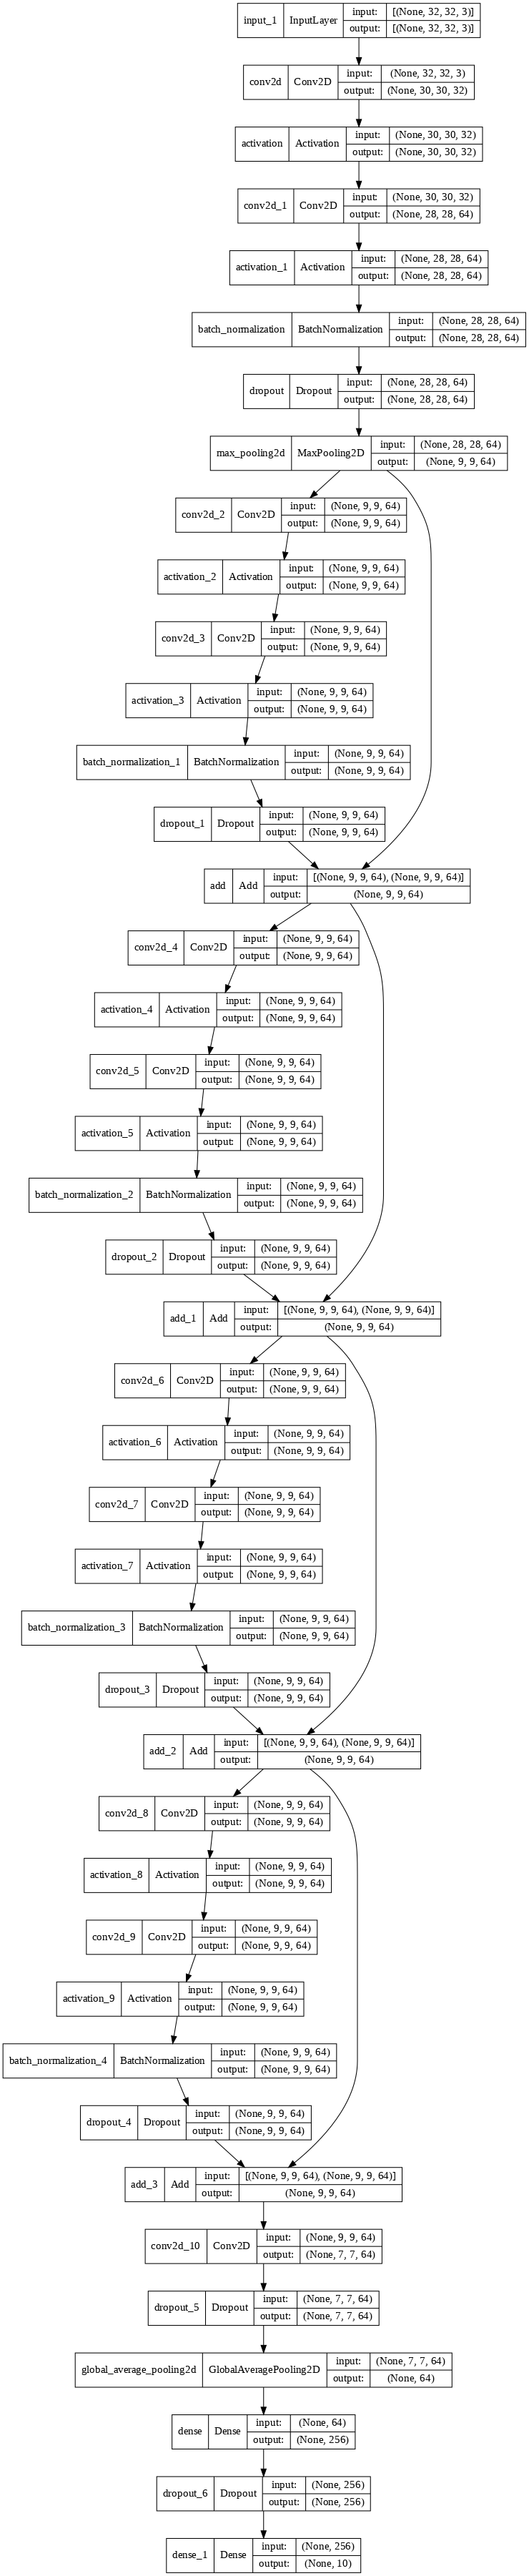

In [14]:
# Uncomment the following line to plot the model visually - warning this may be quite large!
keras.utils.plot_model(model, show_shapes=True, dpi=75)

In [15]:
# input_shape = (32,32,3)
# model = network_top_vgg(input_shape=input_shape)
# model.compile(loss='SparseCategoricalCrossentropy', optimizer=Adam(), metrics=['accuracy'])
# model.summary()

# Uncomment the following line to plot the model visually - warning this may be quite large!
# keras.utils.plot_model(model, dpi=48)


In [16]:
# # Uncomment the following line to plot the model visually - warning this may be quite large!
# keras.utils.plot_model(model, show_shapes=True, dpi=75)

# 5. Model Training

We will now train the complied model on the cifar10 dataset using the tensorflow keras `model.fit` method. 



In [17]:
epochs =40
history = model.fit(train_dataset,
                    epochs=epochs,
                    validation_data=val_dataset)

Epoch 1/40
1407/1407 [==============================] - 46s 25ms/step - loss: 1.3934 - accuracy: 0.4980 - val_loss: 1.4001 - val_accuracy: 0.5236
Epoch 2/40
1407/1407 [==============================] - 30s 21ms/step - loss: 0.9623 - accuracy: 0.6639 - val_loss: 0.9965 - val_accuracy: 0.6613
Epoch 3/40
1407/1407 [==============================] - 30s 21ms/step - loss: 0.7874 - accuracy: 0.7276 - val_loss: 0.8047 - val_accuracy: 0.7240
Epoch 4/40
1407/1407 [==============================] - 29s 21ms/step - loss: 0.6762 - accuracy: 0.7676 - val_loss: 0.8567 - val_accuracy: 0.7313
Epoch 5/40
1407/1407 [==============================] - 30s 21ms/step - loss: 0.5956 - accuracy: 0.7960 - val_loss: 0.7241 - val_accuracy: 0.7649
Epoch 6/40
1407/1407 [==============================] - 30s 21ms/step - loss: 0.5394 - accuracy: 0.8155 - val_loss: 0.7128 - val_accuracy: 0.7776
Epoch 7/40
1407/1407 [==============================] - 30s 21ms/step - loss: 0.4910 - accuracy: 0.8319 - val_loss: 0.7165 -

We will plot the loss and accuracy for the training and validation data sets.

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


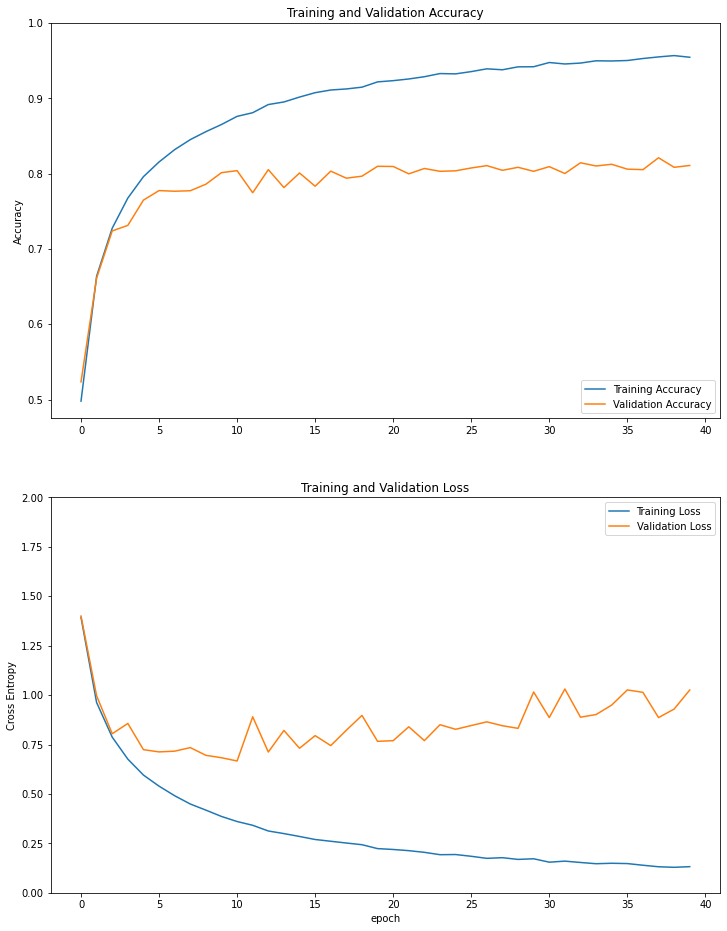

In [18]:
print(history.history.keys())
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 16))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# 6. Model Testing
We will iterate through the test data and analyse the results using tools from sklearn. We create a classification report, a confusion matrix and also plot a few examples from the test set.

Iterate through n_test batches and store the predicted and ground truth labels in numpy arrays.

In [19]:
n_test = 100 # number of batches to use
store_predictions = []
store_labels = []
for image_batch,label_batch in test_dataset.take(n_test):
    predictions = model.predict_on_batch(image_batch) 
    predictions = tf.math.argmax(predictions,axis=1)
    store_predictions.append(predictions)
    store_labels.append(label_batch)
y_pred = np.squeeze(np.reshape(store_predictions,(1,n_test*batch_size)))
y_true = np.squeeze(np.reshape(store_labels,(1,n_test*batch_size)))


Create and plot a confusion matrix.

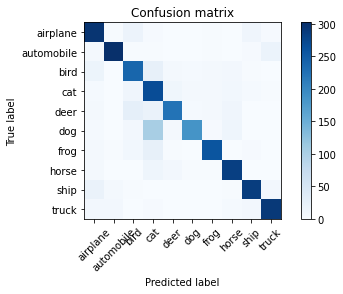

In [20]:
#https://scikit-learn.org/0.16/auto_examples/model_selection/plot_confusion_matrix.html
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(label_str))
    plt.xticks(tick_marks, label_str, rotation=45)
    plt.yticks(tick_marks, label_str)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(cm)

Generate & print the classification report

In [21]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=label_str))

              precision    recall  f1-score   support

    airplane       0.80      0.88      0.83       337
  automobile       0.94      0.89      0.92       338
        bird       0.76      0.78      0.77       306
         cat       0.58      0.83      0.68       323
        deer       0.86      0.75      0.80       297
         dog       0.92      0.57      0.70       325
        frog       0.90      0.84      0.87       307
       horse       0.85      0.90      0.87       317
        ship       0.90      0.88      0.89       326
       truck       0.89      0.90      0.89       324

    accuracy                           0.82      3200
   macro avg       0.84      0.82      0.82      3200
weighted avg       0.84      0.82      0.82      3200



Plot some test images and predicted labels.

(32, 10)
(32,)
Predictions:
 [7 0 6 9 5 1 7 0 7 4 7 2 7 9 0 0 8 8 7 9 4 2 3 5 3 2 2 8 1 8 2 0]


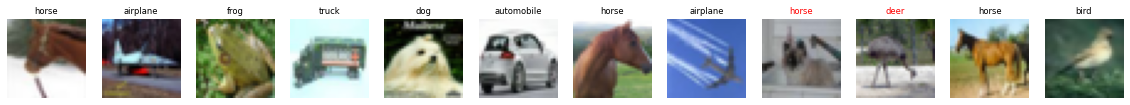

In [22]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)
print(np.shape(predictions))
# Apply a sigmoid since our model returns logits
predictions = tf.math.argmax(predictions,axis=1)
print(np.shape(predictions))
print('Predictions:\n', predictions.numpy())


i=0
n_plots = 12 # number of plots
f, axarr = plt.subplots(1,n_plots,figsize=(20,10))

for image in image_batch[0:n_plots,:,:,:]:  # Only take a single example
  axarr[i].imshow(image[:,:,:]+0.5)
  axarr[i].axis('off')
  
  color = ('black' if predictions[i] == int(label_batch[i]) else 'red') 
  axarr[i].set_title(label_str[int(predictions[i])],fontsize='small', color=color)
  i = i+1

# Please Leave a note here explaining your approach/results for the e-moderator.

